In [5]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from keras.models import Model
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPool2D,Conv2DTranspose, concatenate,Input
from keras import backend as K

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
for dirname, _, filenames in os.walk('mads'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Paths to our images and masks folders
imgs_dir = 'Microscopy/images'
masks_dir = 'Microscopy/masks'       

mads/images/Jazz_Jazz3_C2_00450.png
mads/images/Taichi_S5_C1_00630.png
mads/images/Taichi_S4_C2_00045.png
mads/images/Kata_N3_C2_00090.png
mads/images/Taichi_S4_C1_00405.png
mads/images/Jazz_Jazz2_C1_00450.png
mads/images/Taichi_S3_C0_00405.png
mads/images/Kata_F3_C0_00360.png
mads/images/HipHop_HipHop6_C0_00225.png
mads/images/Jazz_Jazz1_C0_00180.png
mads/images/HipHop_HipHop2_C0_00270.png
mads/images/Jazz_Jazz3_C1_00225.png
mads/images/Sports_Tennis_C2_00225.png
mads/images/Kata_F4_C0_00270.png
mads/images/Jazz_Jazz5_C0_00585.png
mads/images/HipHop_HipHop4_C1_00180.png
mads/images/HipHop_HipHop3_C0_00540.png
mads/images/Taichi_S5_C0_00090.png
mads/images/Kata_P3_C2_00360.png
mads/images/Taichi_S5_C1_00405.png
mads/images/HipHop_HipHop5_C2_00450.png
mads/images/Jazz_Jazz4_C0_00765.png
mads/images/Jazz_Jazz4_C1_00720.png
mads/images/Taichi_S2_C0_00585.png
mads/images/Taichi_S3_C0_00720.png
mads/images/Taichi_S2_C2_00405.png
mads/images/Kata_F3_C1_00405.png
mads/images/Kata_F4_C1_00585.

In [7]:
imgs_arr = np.zeros((len(os.listdir(imgs_dir)), 256, 256, 3), dtype = np.float32)
masks_arr = np.zeros((len(os.listdir(masks_dir)), 256, 256, 1), dtype = np.float32)

for index in range(len(os.listdir(imgs_dir))):
    img = load_img(os.path.join(imgs_dir, os.listdir(imgs_dir)[index]), target_size = (256, 256, 3))
    imgs_arr[index] = img_to_array(img)
    
for index in range(len(os.listdir(masks_dir))):
    img = load_img(os.path.join(masks_dir, os.listdir(masks_dir)[index]), target_size = (256, 256, 1), color_mode="grayscale" )
    masks_arr[index] = img_to_array(img)

imgs_arr /= 255.
masks_arr /= 255.

x_train = imgs_arr[10:]
y_train = masks_arr[10:]

x_test = imgs_arr[0:10]
y_test = masks_arr[0:10]

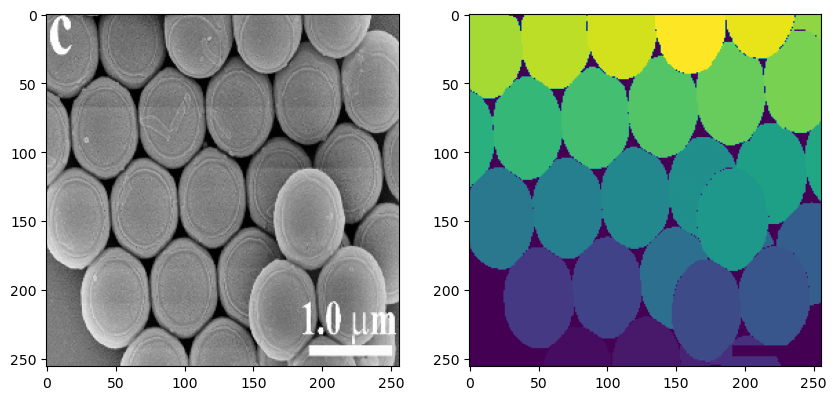

In [8]:
# Plotting image and its mask 
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
plt.imshow(imgs_arr[0])
f.add_subplot(1,2, 2)
plt.imshow(masks_arr[0])
plt.show(block=True)

In [9]:
# Convolutional blocks
def conv_block(inputs,n_filters,max_pool=True):
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Conv2D(n_filters,3,padding='same',kernel_initializer='he_normal',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    skip = x
    if max_pool:
        next_layer = MaxPool2D()(x)
    else:
        next_layer = x
    return next_layer, skip

# upsampling block 
def up_block(reg_inputs,skip_inputs,n_filters):
    x = Conv2DTranspose(n_filters,3,2,padding='same')(reg_inputs)
    x = concatenate([x,skip_inputs],axis=3)
    x = conv_block(x,n_filters,max_pool=False)[0]
    return x

In [10]:
# Unet model
def unet(input_size=(256,256,3),number_of_classes=1):
    inputs = Input(shape=input_size)
    cb1 = conv_block(inputs,32)
    cb2 = conv_block(cb1[0],64)
    cb3 = conv_block(cb2[0],128)
    cb4 = conv_block(cb3[0],256)
    cb5 = conv_block(cb4[0],512,max_pool=False)
    
    up1 = up_block(cb5[0],cb4[1],256)
    up2 = up_block(up1,cb3[1],128)
    up3 = up_block(up2,cb2[1],64)
    up4 = up_block(up3,cb1[1],32)
    
    conv1 = Conv2D(32,3,padding='same',kernel_initializer='he_normal',use_bias=False)(up4)
    bn = BatchNormalization()(conv1)
    lrl = LeakyReLU(0.2)(bn)
    outputs = Conv2D(number_of_classes,1,padding='same',activation='sigmoid')(lrl)
    
    unet = Model(inputs=inputs,outputs=outputs)
    return unet

In [11]:
# Jaccard coeficient or IoU
def jaccard_coef(y_true,y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return (intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection+smooth)
# Jaccard loss
def jaccard_loss(y_true,y_pred,smooth=1):
    return -jaccard_coef(y_true,y_pred,smooth)

2023-02-02 22:57:13.424668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-02 22:57:13.424711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-02-02 22:57:13.425084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


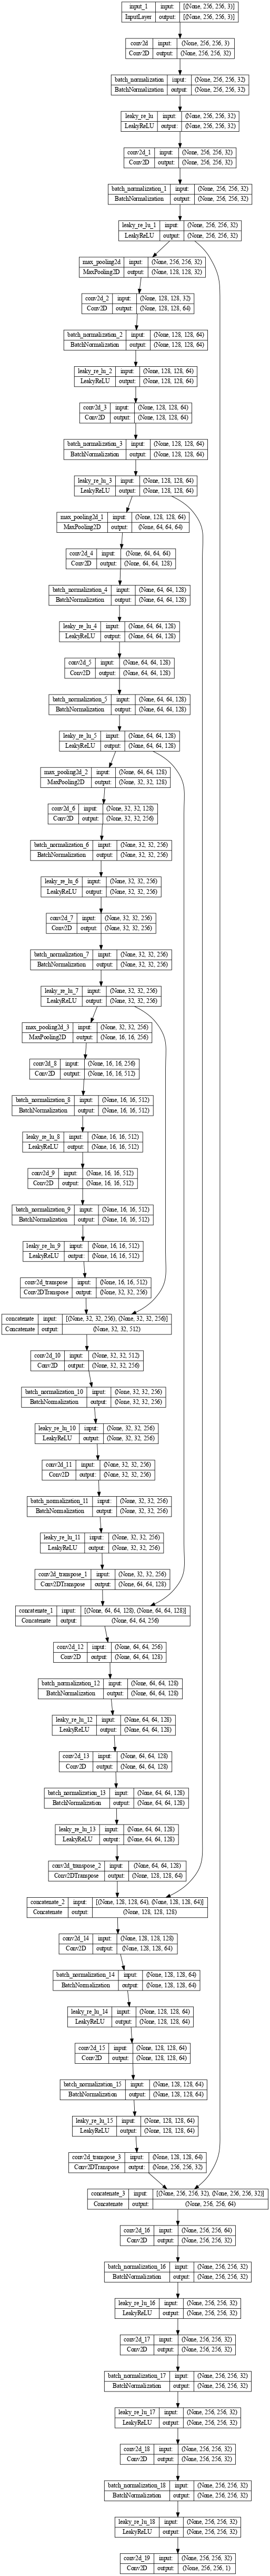

In [12]:
# Defining our model
model = unet()

# Plotting our model
keras.utils.plot_model( model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=60)

In [13]:
nepoch=1
nbsize=16
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=[jaccard_loss],metrics=[jaccard_coef])
history = model.fit(x_train,y_train,batch_size=nbsize,epochs=nepoch,validation_split=0.2)

23/23 [==============================] - 465s 20s/step - loss: -0.0443 - jaccard_coef: 0.0443 - val_loss: -0.0047 - val_jaccard_coef: 0.0045


ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

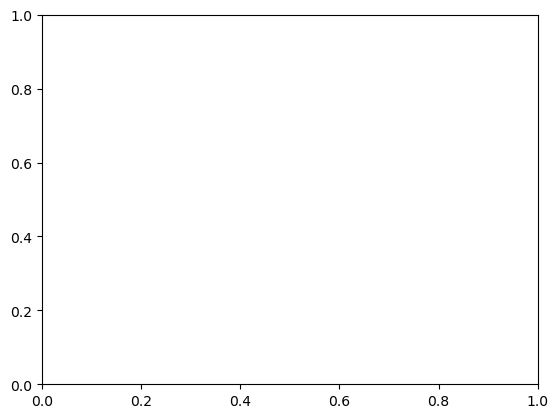

In [14]:
# Plotting loss change over epochs
x = [i for i in range(20)]
plt.plot(x,history.history['loss'])
plt.title('change in loss over epochs')
plt.legend(['jaccard_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

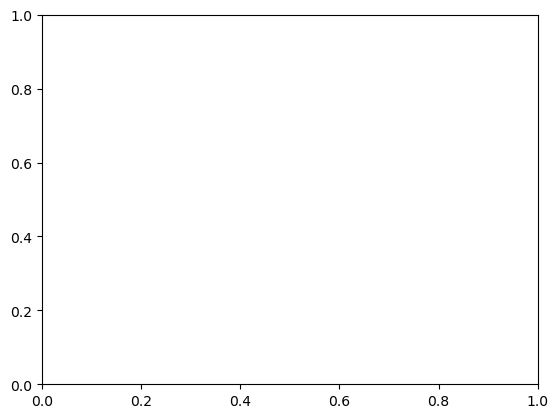

In [15]:
# Plotting IoU change over epochs
x = [i for i in range(20)]
plt.plot(x,history.history['jaccard_coef'])
plt.title('change in jaccard coefitient over epochs')
plt.legend(['jaccard coefitient'])
plt.xlabel('epochs')
plt.ylabel('jaccard coefitient')
plt.show()

In [16]:
predictions = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


In [17]:
def create_mask(predictions,input_shape=(256,256,1)):
    mask = np.zeros(input_shape)
    mask[predictions>0.5] = 1
    return mask

In [18]:
# Ploting results for one image
def plot_results_for_one_sample(sample_index):
    mask = create_mask(predictions[sample_index])
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4,1)
    plt.title('Input image')
    plt.imshow(x_test[sample_index])
    f.add_subplot(1,4,2)
    plt.title('Real mask')
    plt.imshow(y_test[sample_index])
    f.add_subplot(1,4,3)
    plt.title('Predicted mask')
    plt.imshow(mask)
    f.add_subplot(1,4,4)
    plt.title("Mask + image")
    plt.imshow(x_test[sample_index]*mask)

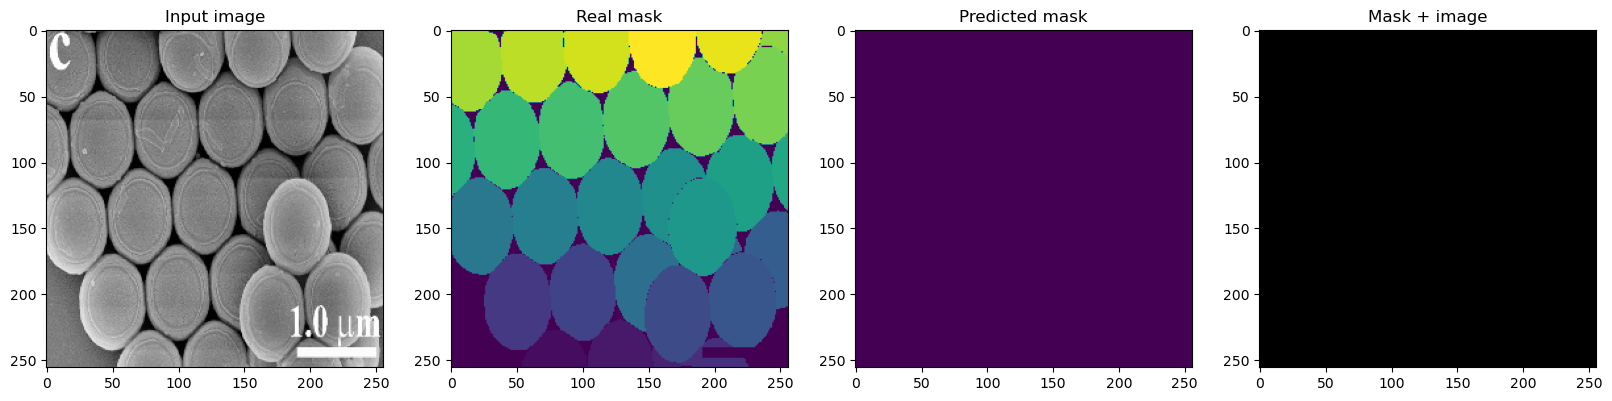

In [19]:
plot_results_for_one_sample(0)

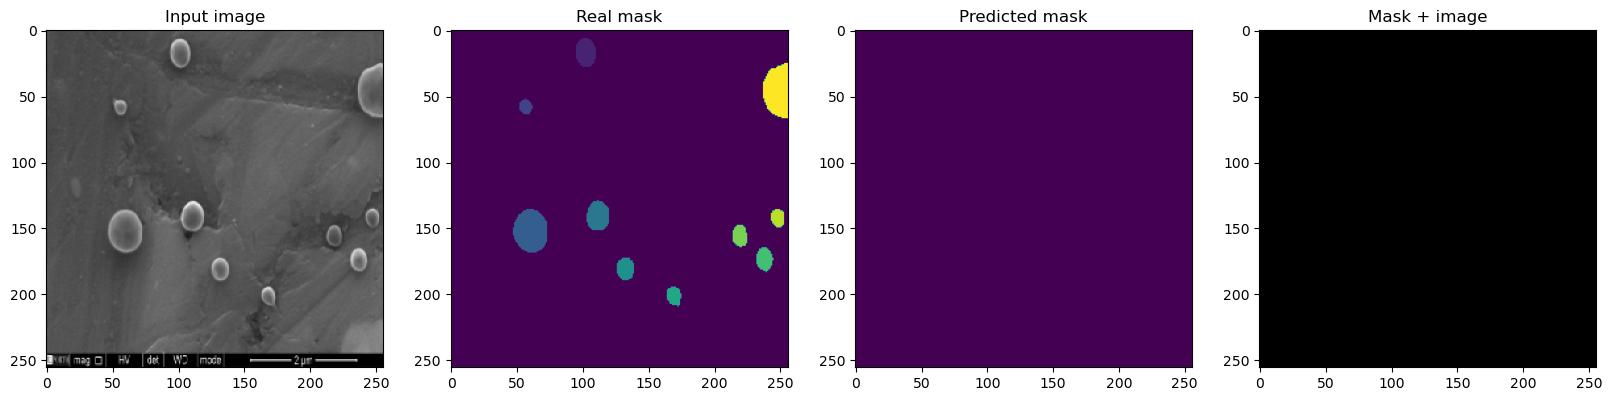

In [20]:
plot_results_for_one_sample(1)

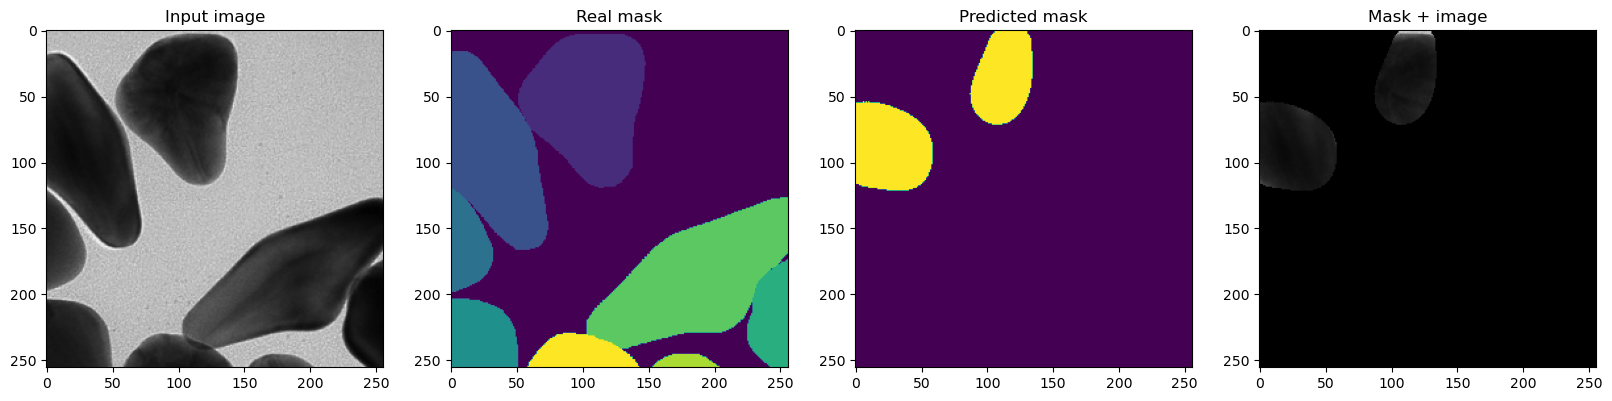

In [21]:
plot_results_for_one_sample(2)